In [1]:
%matplotlib inline
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
import seaborn as sns

In [2]:
dt = 0.05
t1 = -3
t2 = 3
k = 5

Тестовые данные для сравнения моделей

In [3]:
def func(t):
    return np.cos(4 * np.pi * t)

In [4]:
def X_Y(k, dt):
    T = np.arange(t1, t2, dt)
    F = func(T)
    Fs = []
    X = []
    Y = []
    Ts = []
    for i in range(len(T)-k-1):
        Xs = []
        for j in range(k):
            Xs.append(F[i+j])
        X.append(Xs)
        Y.append(F[i+k])
        Ts.append(T[i+k])
        Fs.append(F[i+k])
    return Fs, Ts, np.array(X), np.array(Y)

Функция, создающая 4 массива:
- Ts - Массив значений параметра t, который соответвует значениям функции из массива Y
- X - Двумерный массив значений функции F, выбранной в порядке k идущих подряд, начиная с первого по максимально возможный индекс из массива F. Является данными, подающимися на вход модели
- Y - Массив значений функции F, начиная с k+1-й позиции, до последней. Должен являться результатом прогнозирования
- Fs - Массив значений функции F, который соответвует значениям функции из массива Ts

In [5]:
F, T, X, Y = X_Y(k, dt)

In [6]:
scaler = MinMaxScaler(feature_range = (0, 1))
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(np.reshape(Y, (Y.shape[0],1)))

Преобразование данных X и Y с помощью масштабирования

In [7]:
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.4, random_state=42)
X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)

Разделение данных на обучающу, тестовую и валидационную выборку в отношении 60/20/20 %

In [8]:
net_dense = Sequential()
net_dense.add(Input(shape=(X_train.shape[1],)))
net_dense.add(Dense(units=64))
net_dense.add(Dense(units=32))
net_dense.add(Dense(units=1))

net_dense_2 = Sequential()
net_dense_2.add(Input(shape=(X_train.shape[1],)))
net_dense_2.add(Dense(units=64))
net_dense_2.add(Dense(units=32))
net_dense_2.add(Dense(units=1))

net = Sequential()
net.add(Input(shape=(X_train.shape[1], 1)))
net.add(GRU(units=64, return_sequences=True))
net.add(GRU(units=32))
net.add(Dense(units=1))

net_2 = Sequential()
net_2.add(Input(shape=(X_train.shape[1], 1)))
net_2.add(GRU(units=64, return_sequences=True))
net_2.add(GRU(units=32))
net_2.add(Dense(units=1))

Создание 4-х моделей:
- Полносвязная модель для масштабированных данных
- Полносвязная модель для немасштабированных данных
- Модель на основе GRU блоков для масштабированных данных
- Модель на основе GRU блоков для немасштабированных данных

In [9]:
net_dense.compile(optimizer='adam', loss='mean_squared_error')
history = net_dense.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_dev, Y_dev))
mse = net_dense.evaluate(X_test, Y_test)
Y_1 = net_dense.predict(X_test)
r2 = r2_score(Y_test, Y_1)
print(f'Минимальная квадратичная ошибка на тестовых данных полносвязной модели без масштабирования: {mse}, R2: {r2}')


net.compile(optimizer='adam', loss='mean_squared_error')
history = net.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], 1)), Y_dev))
mse = net.evaluate(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)), Y_test)
Y_1 = net.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))
r2 = r2_score(Y_test, Y_1)
print(f'Минимальная квадратичная ошибка на тестовых данных модели с GRU слоем без масштабирования: {mse}, R2: {r2}')


X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)
X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)

net_dense_2.compile(optimizer='adam', loss='mean_squared_error')
history = net_dense_2.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_dev, Y_dev))
mse = net_dense_2.evaluate(X_test, Y_test)
Y_1 = net_dense_2.predict(X_test)
r2 = r2_score(Y_test, Y_1)
print(f'Минимальная квадратичная ошибка на тестовых данных полносвязной модели с масштабированием: {mse}, R2: {r2}')

net_2.compile(optimizer='adam', loss='mean_squared_error')
history = net_2.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], 1)), Y_dev))
mse = net_2.evaluate(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)), Y_test)
Y_1 = net_2.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))
r2 = r2_score(Y_test, Y_1)
print(f'Минимальная квадратичная ошибка на тестовых данных модели с GRU слоем с маштабированием: {mse}, R2: {r2}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0090e-12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Минимальная квадратичная ошибка на тестовых данных полносвязной модели без масштабирования: 1.0090478799740232e-12, R2: 0.9999999999980689
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.5326e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
Минимальная квадратичная ошибка на тестовых данных модели с GRU слоем без масштабирования: 4.5326498366193846e-05, R2: 0.999912407875596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.2351e-14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Минимальная квадратичная ошибка на тестовых данных полносвязной модели с масштабированием: 1.2351231148954867e-14, R2: 0.9999999999998347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.9625e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
Минимальная квадратичная ошибка на тестовых данных модели с GRU слоем с маштабированием: 1.962499663932249e-05, R2: 0.999731624228871


В результате анализа точности четырёх моделей, лучшей оказалась полносвязная модель с масштабированием

In [10]:
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.4, random_state=42)
X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)

Y_1 = net_dense.predict(X_test)
print (X_test[0], " ->", Y_1[0])
# T_test.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699]  -> [-0.9999993]


Построим графики зависимостей ошибки mse и r2 от параметров k и dt для каждой модели

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.4235e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.1786e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.2790e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.1749e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
mse: [0.00034234681515954435, 3.178641782142222e-05, 2.279013096995186e-05, 2.1749490770162083e-05] k: [3, 4, 5, 6] r2s: [0.9971687907188768, 0.9997371252653775, 0.9998238347874795, 0.9998373562066524]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9429e-05 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6170e-05 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6414e-05 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.3183e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31

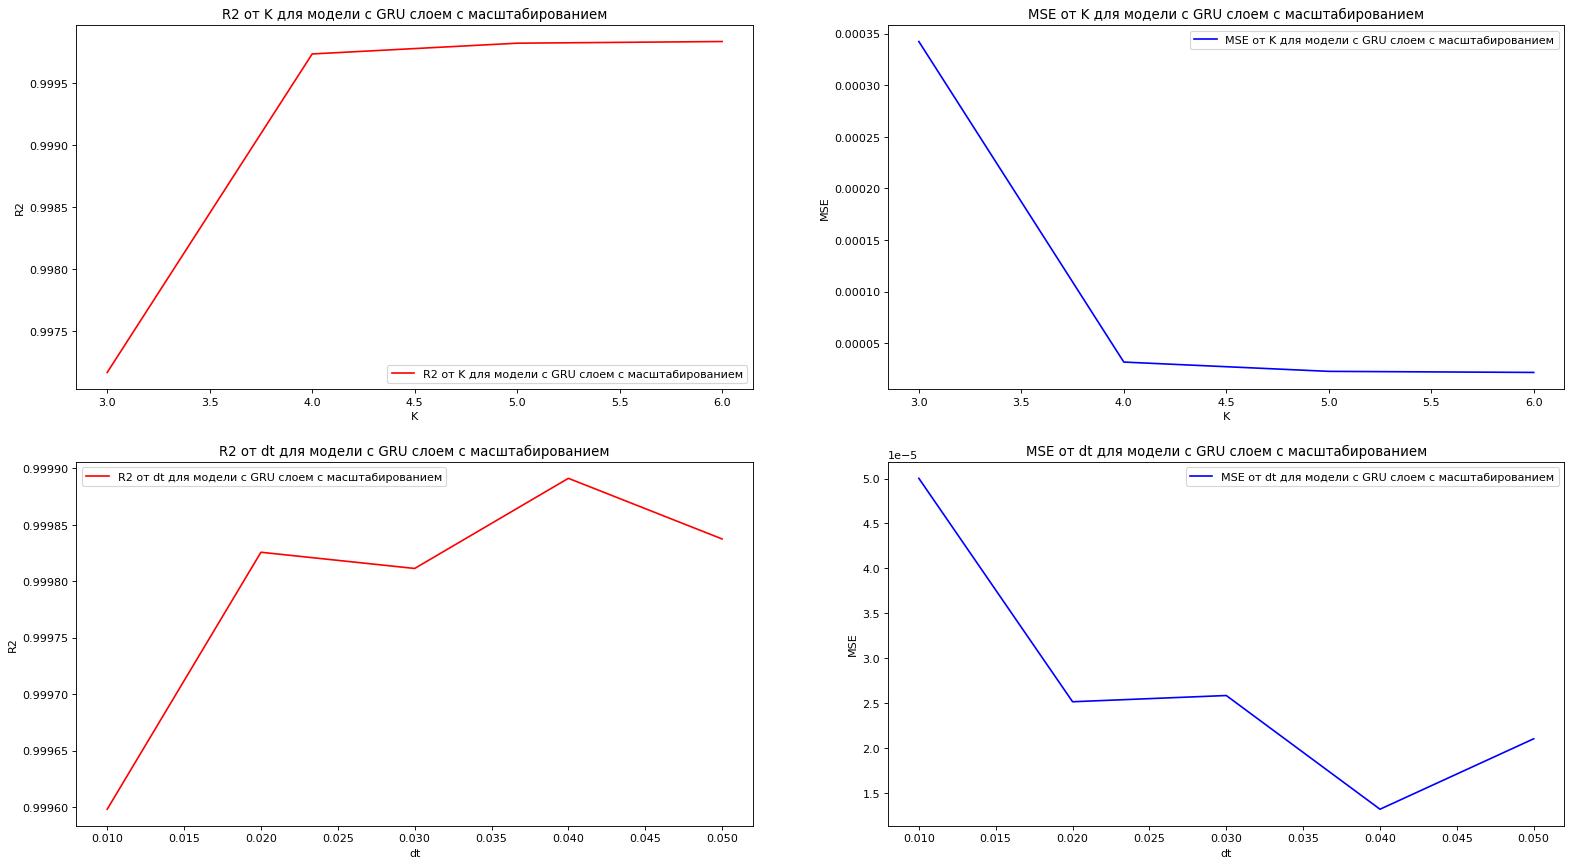

In [12]:
ks = []
mses = []
r2s = []
for k in range(3, 7):
    F, T, X, Y = X_Y(k, dt)
    scaler = MinMaxScaler(feature_range = (0, 1))
    X_scaled = scaler.fit_transform(X)
    Y_scaled = scaler.fit_transform(np.reshape(Y, (Y.shape[0],1)))
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X_scaled, Y_scaled, T, test_size=0.4, random_state=42)
    X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
    net = Sequential()
    net.add(Input(shape=(X_train.shape[1], 1)))
    net.add(GRU(units=64, return_sequences=True))
    net.add(GRU(units=32))
    net.add(Dense(units=1))
    
    net.compile(optimizer='adam', loss='mean_squared_error')
    history = net.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], 1)), Y_dev))
    mse = net.evaluate(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)), Y_test)
    Y_1 = net.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))
    r2 = r2_score(Y_test, Y_1)
    ks.append(k)
    mses.append(mse)
    r2s.append(r2)
print(f'mse: {mses} k: {ks} r2s: {r2s}')

fig, axs = plt.subplots(2, 2, figsize=(24, 13), dpi=80)

axs[0, 0].plot(ks, r2s, color='r', label='R2 от K для модели с GRU слоем с масштабированием')
axs[0, 0].set_xlabel("K")
axs[0, 0].set_ylabel("R2")
axs[0, 0].set_title("R2 от K для модели с GRU слоем с масштабированием")
axs[0, 0].legend()

axs[0, 1].plot(ks, mses, color='b', label='MSE от K для модели с GRU слоем с масштабированием')
axs[0, 1].set_xlabel("K")
axs[0, 1].set_ylabel("MSE")
axs[0, 1].set_title("MSE от K для модели с GRU слоем с масштабированием")
axs[0, 1].legend()


dts = []
mses = []
r2s = []
k = 5
dt=0.01
while dt <= 0.05:
    F, T, X, Y = X_Y(k, dt)
    scaler = MinMaxScaler(feature_range = (0, 1))
    X_scaled = scaler.fit_transform(X)
    Y_scaled = scaler.fit_transform(np.reshape(Y, (Y.shape[0],1)))
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X_scaled, Y_scaled, T, test_size=0.4, random_state=42)
    X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
    
    net = Sequential()
    net.add(Input(shape=(X_train.shape[1], 1)))
    net.add(GRU(units=64, return_sequences=True))
    net.add(GRU(units=32))
    net.add(Dense(units=1))
    
    net.compile(optimizer='adam', loss='mean_squared_error')
    history = net.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], 1)), Y_dev))
    mse = net.evaluate(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)), Y_test)
    Y_1 = net.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))
    r2 = r2_score(Y_test, Y_1)
    dts.append(dt)
    mses.append(mse)
    r2s.append(r2)
    dt += 0.01
print(f'mse: {mses} dt: {dts} r2s: {r2s}')


axs[1, 0].plot(dts, r2s, color='r', label='R2 от dt для модели с GRU слоем с масштабированием')
axs[1, 0].set_xlabel("dt")
axs[1, 0].set_ylabel("R2")
axs[1, 0].set_title("R2 от dt для модели с GRU слоем с масштабированием")
axs[1, 0].legend()

axs[1, 1].plot(dts, mses, color='b', label='MSE от dt для модели с GRU слоем с масштабированием')
axs[1, 1].set_xlabel("dt")
axs[1, 1].set_ylabel("MSE")
axs[1, 1].set_title("MSE от dt для модели с GRU слоем с масштабированием")
axs[1, 1].legend()

plt.show()

По графикам видно, что для полносвязной модели с GRU блоками и маштабированием лучшим значение k является 6, а лучшим значением dt 0.04

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.5278e-09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.0388e-11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.7013e-10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.0879e-11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
mse: [1.5277893394838316e-09, 7.038838262252156e-11, 2.701316392794695e-10, 4.087916463668684e-11] k: [3, 4, 5, 6] r2s: [0.9999999886632542, 0.9999999994914807, 0.9999999973629357, 0.9999999996510779]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4796e-14 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7944e-15 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3564e-15 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.4048e-15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step -

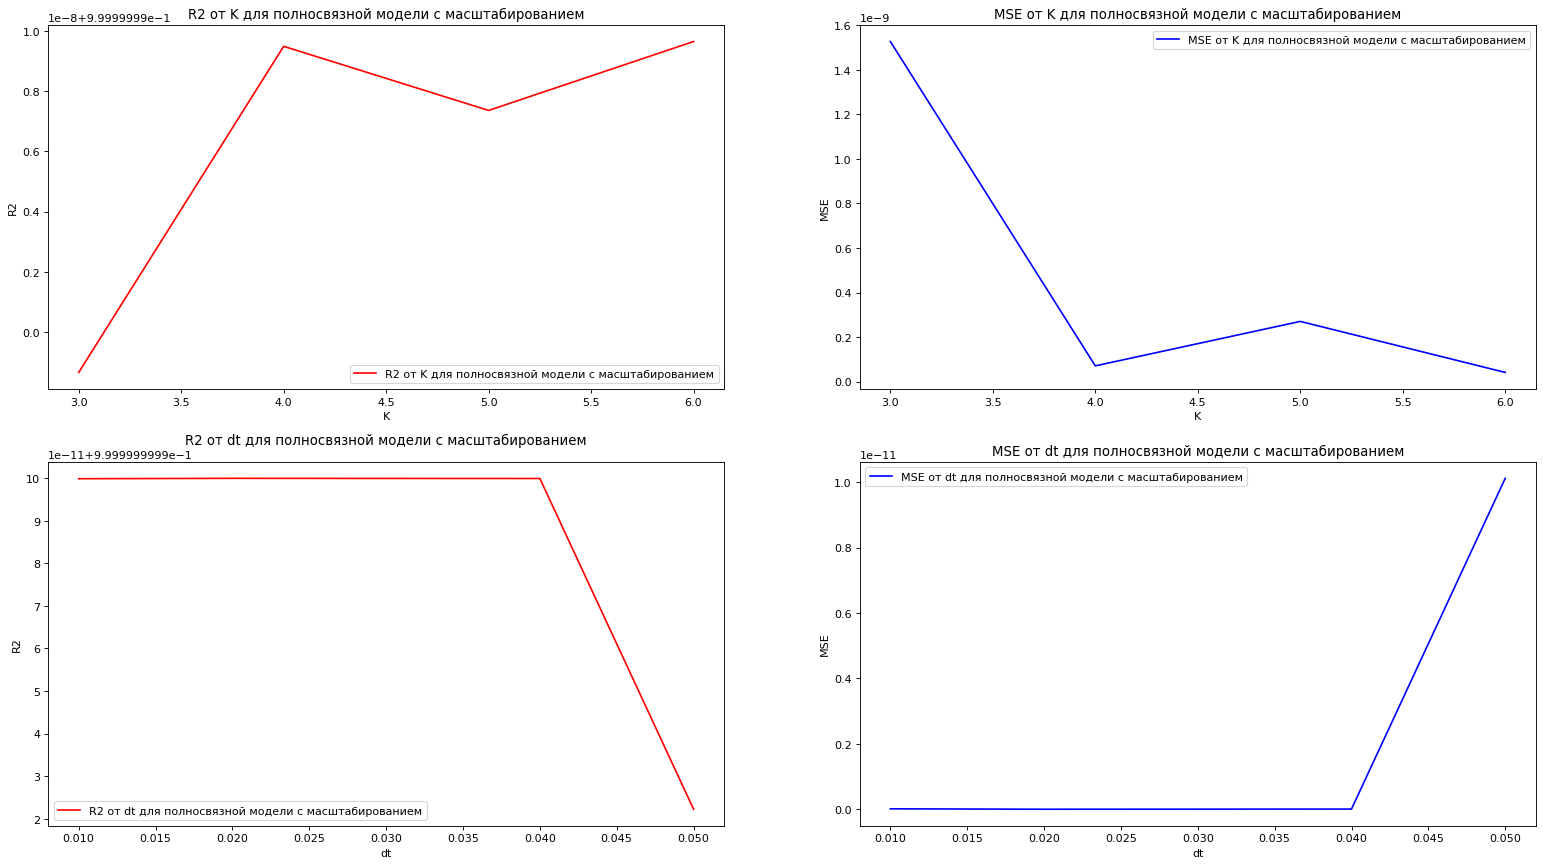

In [13]:
ks = []
mses = []
r2s = []
for k in range(3, 7):
    F, T, X, Y = X_Y(k, dt)
    scaler = MinMaxScaler(feature_range = (0, 1))
    X_scaled = scaler.fit_transform(X)
    Y_scaled = scaler.fit_transform(np.reshape(Y, (Y.shape[0],1)))
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X_scaled, Y_scaled, T, test_size=0.4, random_state=42)
    X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
    net_dense_test = Sequential()
    net_dense_test.add(Input(shape=(X_train.shape[1],)))
    net_dense_test.add(Dense(units=64))
    net_dense_test.add(Dense(units=32))
    net_dense_test.add(Dense(units=1))
    
    net_dense_test.compile(optimizer='adam', loss='mean_squared_error')
    history = net_dense_test.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_dev, Y_dev))
    mse = net_dense_test.evaluate(X_test, Y_test)
    Y_1 = net_dense_test.predict(X_test)
    r2 = r2_score(Y_test, Y_1)
    ks.append(k)
    mses.append(mse)
    r2s.append(r2)
print(f'mse: {mses} k: {ks} r2s: {r2s}')

fig, axs = plt.subplots(2, 2, figsize=(24, 13), dpi=80)

axs[0, 0].plot(ks, r2s, color='r', label='R2 от K для полносвязной модели с масштабированием')
axs[0, 0].set_xlabel("K")
axs[0, 0].set_ylabel("R2")
axs[0, 0].set_title("R2 от K для полносвязной модели с масштабированием")
axs[0, 0].legend()

axs[0, 1].plot(ks, mses, color='b', label='MSE от K для полносвязной модели с масштабированием')
axs[0, 1].set_xlabel("K")
axs[0, 1].set_ylabel("MSE")
axs[0, 1].set_title("MSE от K для полносвязной модели с масштабированием")
axs[0, 1].legend()


dts = []
mses = []
r2s = []
k = 5
dt=0.01
while dt <= 0.05:
    F, T, X, Y = X_Y(k, dt)
    scaler = MinMaxScaler(feature_range = (0, 1))
    X_scaled = scaler.fit_transform(X)
    Y_scaled = scaler.fit_transform(np.reshape(Y, (Y.shape[0],1)))
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X_scaled, Y_scaled, T, test_size=0.4, random_state=42)
    X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
    
    net_dense_test = Sequential()
    net_dense_test.add(Input(shape=(X_train.shape[1],)))
    net_dense_test.add(Dense(units=64))
    net_dense_test.add(Dense(units=32))
    net_dense_test.add(Dense(units=1))
    
    net_dense_test.compile(optimizer='adam', loss='mean_squared_error')
    history = net_dense_test.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_dev, Y_dev))
    mse = net_dense_test.evaluate(X_test, Y_test)
    Y_1 = net_dense_test.predict(X_test)
    r2 = r2_score(Y_test, Y_1)
    dts.append(dt)
    mses.append(mse)
    r2s.append(r2)
    dt += 0.01
print(f'mse: {mses} dt: {dts} r2s: {r2s}')


axs[1, 0].plot(dts, r2s, color='r', label='R2 от dt для полносвязной модели с масштабированием')
axs[1, 0].set_xlabel("dt")
axs[1, 0].set_ylabel("R2")
axs[1, 0].set_title("R2 от dt для полносвязной модели с масштабированием")
axs[1, 0].legend()

axs[1, 1].plot(dts, mses, color='b', label='MSE от dt для полносвязной модели с масштабированием')
axs[1, 1].set_xlabel("dt")
axs[1, 1].set_ylabel("MSE")
axs[1, 1].set_title("MSE от dt для полносвязной модели с масштабированием")
axs[1, 1].legend()

plt.show()

Для полносвязной модели с маштабированием лучшим значением k является 6, а dt 0.03

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.6286e-11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.3624e-10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.7659e-10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.2236e-11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
mse: [5.6286156291385225e-11, 2.3623511480330706e-10, 9.765873665301683e-10, 7.223639048037356e-11] k: [3, 4, 5, 6] r2s: [0.9999999998946729, 0.9999999995699406, 0.9999999975992807, 0.9999999998446903]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0442e-14 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5684e-15 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6229e-15 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.4723e-14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 

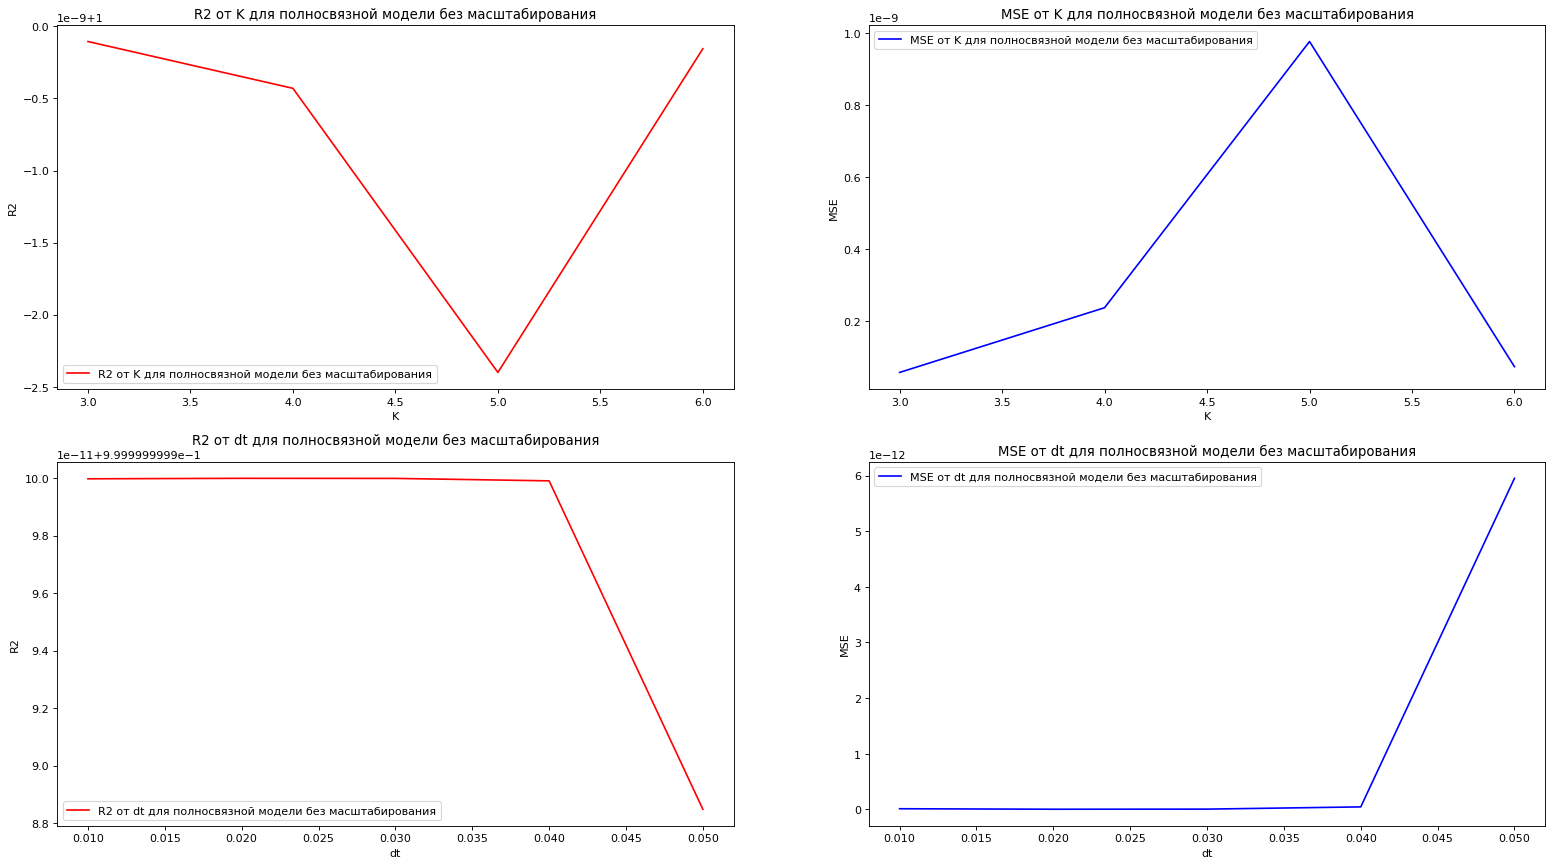

In [14]:
ks = []
mses = []
r2s = []
for k in range(3, 7):
    F, T, X, Y = X_Y(k, dt)
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.4, random_state=42)
    X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
    net_dense_test = Sequential()
    net_dense_test.add(Input(shape=(X_train.shape[1],)))
    net_dense_test.add(Dense(units=64))
    net_dense_test.add(Dense(units=32))
    net_dense_test.add(Dense(units=1))
    
    net_dense_test.compile(optimizer='adam', loss='mean_squared_error')
    history = net_dense_test.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_dev, Y_dev))
    mse = net_dense_test.evaluate(X_test, Y_test)
    Y_1 = net_dense_test.predict(X_test)
    r2 = r2_score(Y_test, Y_1)
    ks.append(k)
    mses.append(mse)
    r2s.append(r2)
print(f'mse: {mses} k: {ks} r2s: {r2s}')

fig, axs = plt.subplots(2, 2, figsize=(24, 13), dpi=80)

axs[0, 0].plot(ks, r2s, color='r', label='R2 от K для полносвязной модели без масштабирования')
axs[0, 0].set_xlabel("K")
axs[0, 0].set_ylabel("R2")
axs[0, 0].set_title("R2 от K для полносвязной модели без масштабирования")
axs[0, 0].legend()

axs[0, 1].plot(ks, mses, color='b', label='MSE от K для полносвязной модели без масштабирования')
axs[0, 1].set_xlabel("K")
axs[0, 1].set_ylabel("MSE")
axs[0, 1].set_title("MSE от K для полносвязной модели без масштабирования")
axs[0, 1].legend()


dts = []
mses = []
r2s = []
k = 5
dt=0.01
while dt <= 0.05:
    F, T, X, Y = X_Y(k, dt)
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.4, random_state=42)
    X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
    
    net_dense_test = Sequential()
    net_dense_test.add(Input(shape=(X_train.shape[1],)))
    net_dense_test.add(Dense(units=64))
    net_dense_test.add(Dense(units=32))
    net_dense_test.add(Dense(units=1))
    
    net_dense_test.compile(optimizer='adam', loss='mean_squared_error')
    history = net_dense_test.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_dev, Y_dev))
    mse = net_dense_test.evaluate(X_test, Y_test)
    Y_1 = net_dense_test.predict(X_test)
    r2 = r2_score(Y_test, Y_1)
    dts.append(dt)
    mses.append(mse)
    r2s.append(r2)
    dt += 0.01
print(f'mse: {mses} dt: {dts} r2s: {r2s}')


axs[1, 0].plot(dts, r2s, color='r', label='R2 от dt для полносвязной модели без масштабирования')
axs[1, 0].set_xlabel("dt")
axs[1, 0].set_ylabel("R2")
axs[1, 0].set_title("R2 от dt для полносвязной модели без масштабирования")
axs[1, 0].legend()

axs[1, 1].plot(dts, mses, color='b', label='MSE от dt для полносвязной модели без масштабирования')
axs[1, 1].set_xlabel("dt")
axs[1, 1].set_ylabel("MSE")
axs[1, 1].set_title("MSE от dt для полносвязной модели без масштабирования")
axs[1, 1].legend()

plt.show()

Для полносвязной модели без масштабирования лучшим значением k является 6, а dt 0.01

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0416e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.9950e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.9030e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.6366e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
mse: [0.00010416422446724027, 4.9950365792028606e-05, 4.903047283733031e-06, 2.6366330985183595e-06] k: [3, 4, 5, 6] r2s: [0.9998052019352158, 0.9999090710470304, 0.9999879450827139, 0.9999943309657016]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5874e-06 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7982e-06 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8058e-05 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.5451e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

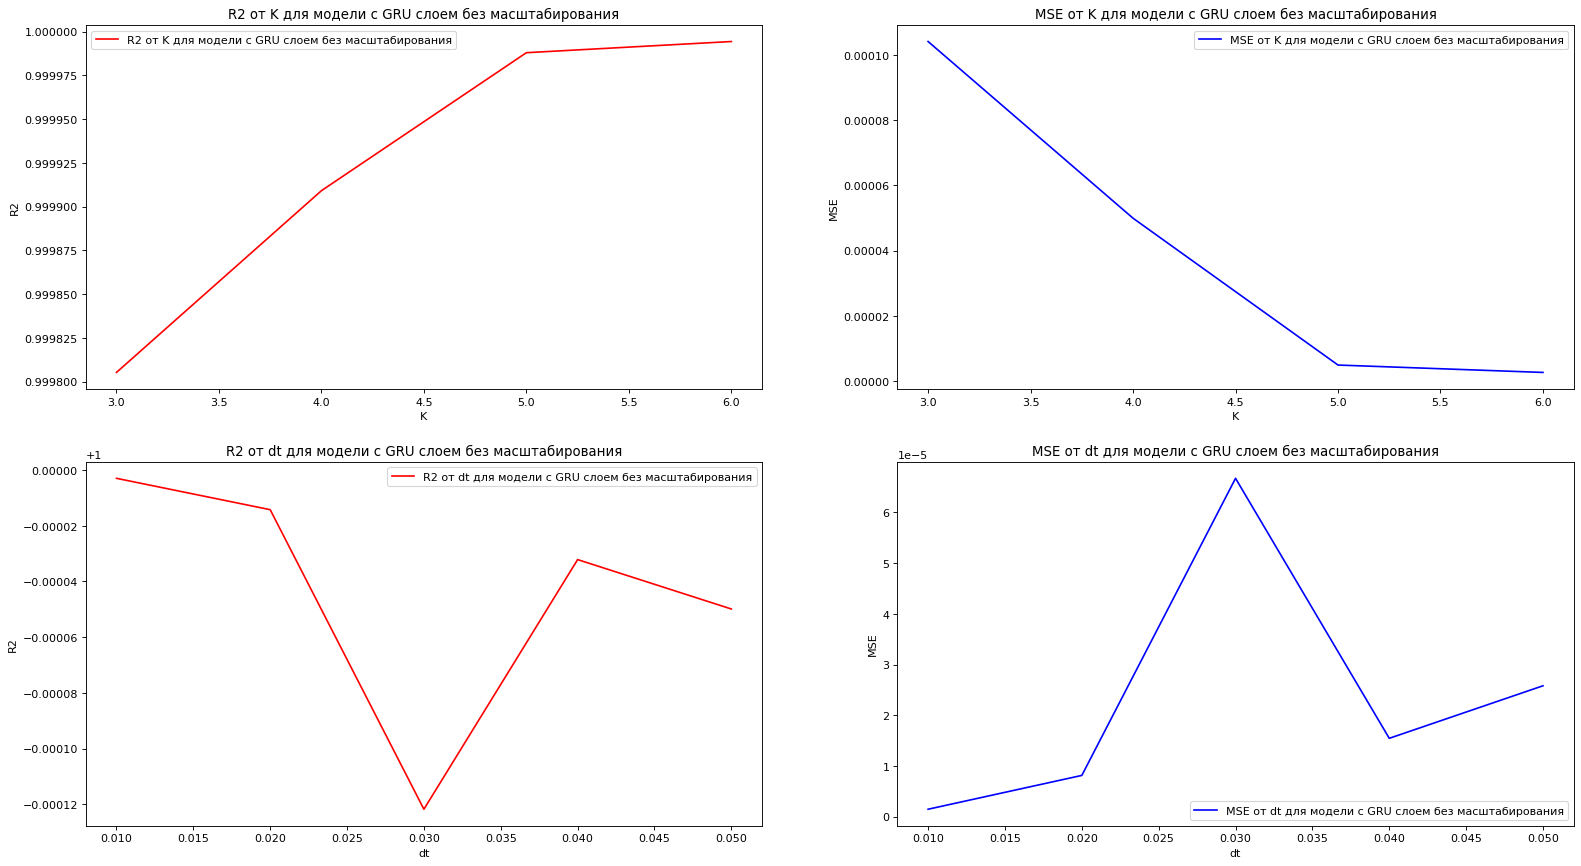

In [15]:
ks = []
mses = []
r2s = []
for k in range(3, 7):
    F, T, X, Y = X_Y(k, dt)
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.4, random_state=42)
    X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
    net = Sequential()
    net.add(Input(shape=(X_train.shape[1], 1)))
    net.add(GRU(units=64, return_sequences=True))
    net.add(GRU(units=32))
    net.add(Dense(units=1))
    
    net.compile(optimizer='adam', loss='mean_squared_error')
    history = net.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], 1)), Y_dev))
    mse = net.evaluate(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)), Y_test)
    Y_1 = net.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))
    r2 = r2_score(Y_test, Y_1)
    ks.append(k)
    mses.append(mse)
    r2s.append(r2)
print(f'mse: {mses} k: {ks} r2s: {r2s}')

fig, axs = plt.subplots(2, 2, figsize=(24, 13), dpi=80)

axs[0, 0].plot(ks, r2s, color='r', label='R2 от K для модели с GRU слоем без масштабирования')
axs[0, 0].set_xlabel("K")
axs[0, 0].set_ylabel("R2")
axs[0, 0].set_title("R2 от K для модели с GRU слоем без масштабирования")
axs[0, 0].legend()

axs[0, 1].plot(ks, mses, color='b', label='MSE от K для модели с GRU слоем без масштабирования')
axs[0, 1].set_xlabel("K")
axs[0, 1].set_ylabel("MSE")
axs[0, 1].set_title("MSE от K для модели с GRU слоем без масштабирования")
axs[0, 1].legend()


dts = []
mses = []
r2s = []
k = 5
dt=0.01
while dt <= 0.05:
    F, T, X, Y = X_Y(k, dt)
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.4, random_state=42)
    X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
    
    net = Sequential()
    net.add(Input(shape=(X_train.shape[1], 1)))
    net.add(GRU(units=64, return_sequences=True))
    net.add(GRU(units=32))
    net.add(Dense(units=1))
    
    net.compile(optimizer='adam', loss='mean_squared_error')
    history = net.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], 1)), Y_dev))
    mse = net.evaluate(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)), Y_test)
    Y_1 = net.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))
    r2 = r2_score(Y_test, Y_1)
    dts.append(dt)
    mses.append(mse)
    r2s.append(r2)
    dt += 0.01
print(f'mse: {mses} dt: {dts} r2s: {r2s}')


axs[1, 0].plot(dts, r2s, color='r', label='R2 от dt для модели с GRU слоем без масштабирования')
axs[1, 0].set_xlabel("dt")
axs[1, 0].set_ylabel("R2")
axs[1, 0].set_title("R2 от dt для модели с GRU слоем без масштабирования")
axs[1, 0].legend()

axs[1, 1].plot(dts, mses, color='b', label='MSE от dt для модели с GRU слоем без масштабирования')
axs[1, 1].set_xlabel("dt")
axs[1, 1].set_ylabel("MSE")
axs[1, 1].set_title("MSE от dt для модели с GRU слоем без масштабирования")
axs[1, 1].legend()

plt.show()

Для модели с GRU блоками без масштабирования лучшим значением k является 6, а dt 0.01

Построим графики рассчитанных значений для каждой модели при её лучших значениях k и dt

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4242e-05 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9216e-15 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1150e-06 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7294e-15 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


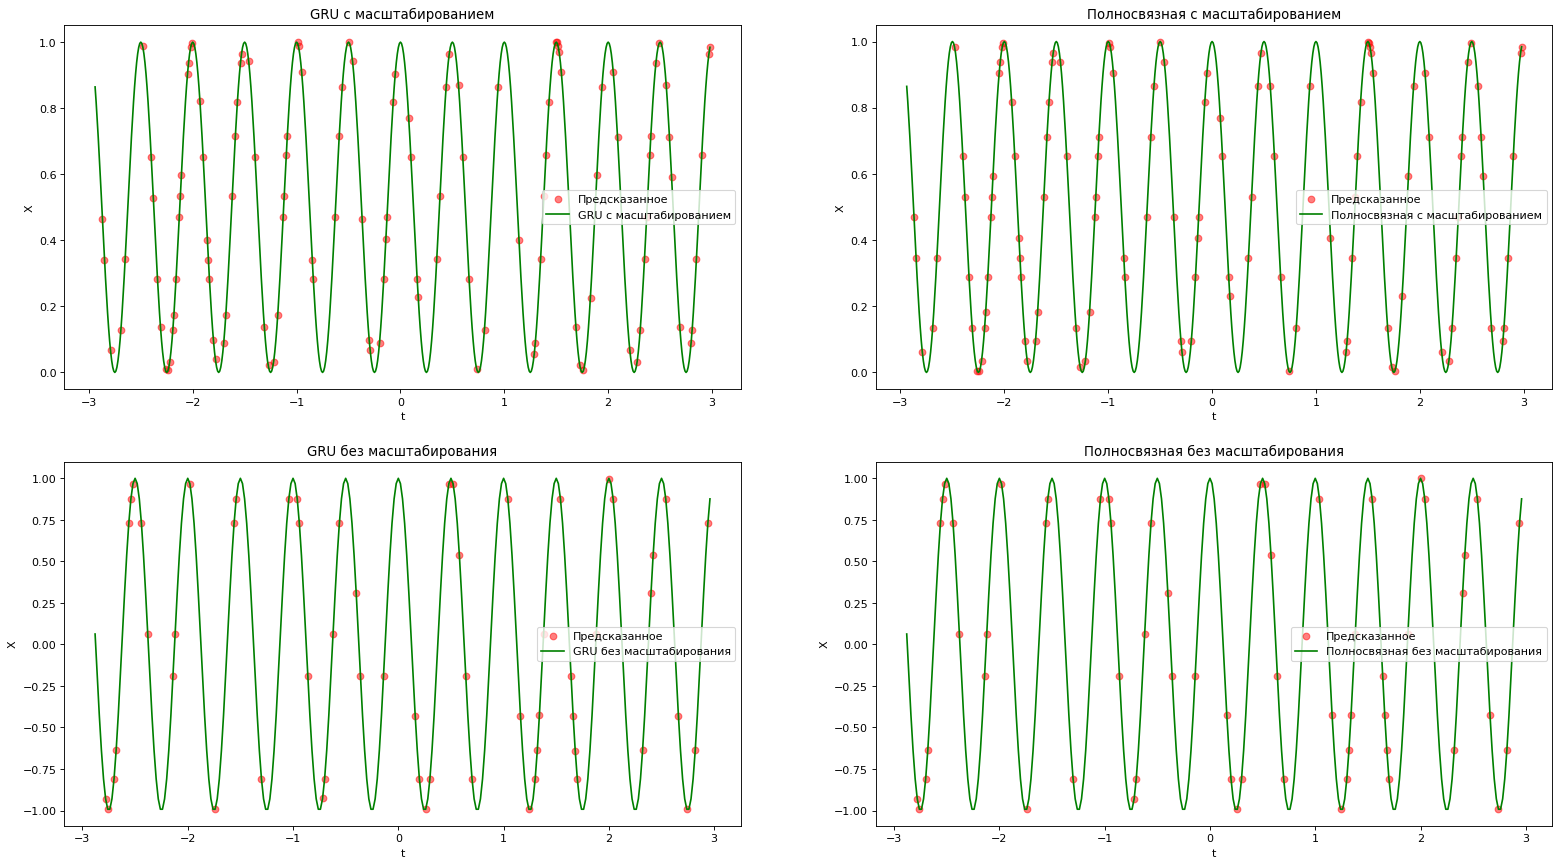

In [16]:
F, T, X, Y = X_Y(6, 0.01)
scaler = MinMaxScaler(feature_range = (0, 1))
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(np.reshape(Y, (Y.shape[0],1)))
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X_scaled, Y_scaled, T, test_size=0.4, random_state=42)
X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
F_scaled = scaler.fit_transform(np.reshape(F, (len(F),1)))
net = Sequential()
net.add(Input(shape=(X_train.shape[1], 1)))
net.add(GRU(units=64, return_sequences=True))
net.add(GRU(units=32))
net.add(Dense(units=1))

net.compile(optimizer='adam', loss='mean_squared_error')
history = net.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], 1)), Y_dev))
mse = net.evaluate(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)), Y_test)
Y_1 = net.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))

fig, axs = plt.subplots(2, 2, figsize=(24, 13), dpi=80)

axs[0, 0].scatter(T_test, Y_1, color='r', label='Предсказанное', alpha=0.5)
axs[0, 0].plot(T, F_scaled, color='g', label='GRU с масштабированием')
axs[0, 0].set_xlabel("t")
axs[0, 0].set_ylabel("X")
axs[0, 0].set_title("GRU с масштабированием")
axs[0, 0].legend()

F, T, X, Y = X_Y(6, 0.01)
scaler = MinMaxScaler(feature_range = (0, 1))
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(np.reshape(Y, (Y.shape[0],1)))
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X_scaled, Y_scaled, T, test_size=0.4, random_state=42)
X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
F_scaled = scaler.fit_transform(np.reshape(F, (len(F),1)))
net_dense_test = Sequential()
net_dense_test.add(Input(shape=(X_train.shape[1],)))
net_dense_test.add(Dense(units=64))
net_dense_test.add(Dense(units=32))
net_dense_test.add(Dense(units=1))

net_dense_test.compile(optimizer='adam', loss='mean_squared_error')
history = net_dense_test.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_dev, Y_dev))
mse = net_dense_test.evaluate(X_test, Y_test)
Y_1 = net_dense_test.predict(X_test)

axs[0, 1].scatter(T_test, Y_1, color='r', label='Предсказанное', alpha=0.5)
axs[0, 1].plot(T, F_scaled, color='g', label='Полносвязная с масштабированием')
axs[0, 1].set_xlabel("t")
axs[0, 1].set_ylabel("X")
axs[0, 1].set_title("Полносвязная с масштабированием")
axs[0, 1].legend()


F, T, X, Y = X_Y(6, 0.02)
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.4, random_state=42)
X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)

net = Sequential()
net.add(Input(shape=(X_train.shape[1], 1)))
net.add(GRU(units=64, return_sequences=True))
net.add(GRU(units=32))
net.add(Dense(units=1))

net.compile(optimizer='adam', loss='mean_squared_error')
history = net.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], 1)), Y_dev))
mse = net.evaluate(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)), Y_test)
Y_1 = net.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))

axs[1, 0].scatter(T_test, Y_1, color='r', label='Предсказанное', alpha=0.5)
axs[1, 0].plot(T, F, color='g', label='GRU без масштабирования')
axs[1, 0].set_xlabel("t")
axs[1, 0].set_ylabel("X")
axs[1, 0].set_title("GRU без масштабирования")
axs[1, 0].legend()

F, T, X, Y = X_Y(6, 0.02)
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.4, random_state=42)
X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)
net_dense_test = Sequential()
net_dense_test.add(Input(shape=(X_train.shape[1],)))
net_dense_test.add(Dense(units=64))
net_dense_test.add(Dense(units=32))
net_dense_test.add(Dense(units=1))

net_dense_test.compile(optimizer='adam', loss='mean_squared_error')
history = net_dense_test.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_dev, Y_dev))
mse = net_dense_test.evaluate(X_test, Y_test)
Y_1 = net_dense_test.predict(X_test)



axs[1, 1].scatter(T_test, Y_1, color='r', label='Предсказанное', alpha=0.5)
axs[1, 1].plot(T, F, color='g', label='Полносвязная без масштабирования')
axs[1, 1].set_xlabel("t")
axs[1, 1].set_ylabel("X")
axs[1, 1].set_title("Полносвязная без масштабирования")
axs[1, 1].legend()
plt.show()

In [17]:
F, T, X, Y = X_Y(6, 0.03)

scaler = MinMaxScaler(feature_range = (0, 1))
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(np.reshape(Y, (Y.shape[0],1)))

X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X_scaled, Y_scaled, T, test_size=0.2, random_state=42)
X_test, X_dev, Y_test, Y_dev, T_test, T_dev = train_test_split(X_test, Y_test, T_test, test_size=0.5, random_state=42)

net_dense = Sequential()
net_dense.add(Input(shape=(X_train.shape[1],)))
net_dense.add(Dense(units=64))
net_dense.add(Dense(units=32))
net_dense.add(Dense(units=1))

net_dense.compile(optimizer='adam', loss='mean_squared_error')
history = net_dense.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_dev, Y_dev))
mse = net_dense.evaluate(X_test, Y_test)
Y_1 = net_dense.predict(X_test)
r2 = r2_score(Y_test, Y_1)
print(f"mse: {mse} r2: {r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.5237e-15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
mse: 2.5237488541460544e-15 r2: 0.999999999999984


Для лучшей модели итоговые значения mse и r2: 2.5*10^-15 и 0.9999999 соответственно